# 4. Adjoint optimization

## Overview

In this tutorial, we will build a simple example application that showcases differentiation and optimization of a light transport simulation involving the well-known Cornell Box scene. We are going to optimize the color of one of the walls of the Cornell Box to match a target image.

Mitsuba’s ability to automatically differentiate entire rendering algorithms builds on differentiable JIT array types provided by the Enoki library. Those are explained in the [Enoki documentation](...). The linked document also discusses key differences compared to superficially similar frameworks like PyTorch and TensorFlow. For *automatic differentiation* (AD), Enoki records and simplifies computation graphs and uses them to propagate derivatives in forward or reverse mode. Before getting further into this tutorial, we recommend that you familiarize yourself this document.

<div class="alert alert-block alert-info">

✔️ **What will you learn?**
    
<ul>
  <li>Passing scene arguments when loading an XML file</li>
  <li>Build an optimization pipeline using the optimizer classes</li>
  <li>Perform gradient-based optimization using automatic differentiation</li>
</ul>
    
</div>


### Step 1 - setup

In order to use the automatic differentiation, we need to enable a variant that supports it. Those are the ones containing `_ad` after the backend description. E.g. `cuda_ad_rgb`, `llvm_ad_rgb`, ... 

In [1]:
# Add mitsuba and enoki to PATH (this shouldn't be necessary)
import sys
sys.path.append('../../../build/python')

In [2]:
from matplotlib import pyplot as plt

import enoki as ek 
import mitsuba
mitsuba.set_variant('llvm_ad_rgb')

It is possible to pass arguments directly to the scene via the `load_file` rountine.

In [3]:
from mitsuba.core.xml import load_file
from mitsuba.python.util import traverse, convert_to_bitmap

def show_image(img, title):
    plt.imshow(convert_to_bitmap(img, crop_size)); plt.axis('off'); plt.title(title);

scene = load_file('../scenes/cbox.xml', res=128, spp=16, max_depth=3, integrator='rb')
crop_size = scene.sensors()[0].film().crop_size()

2021-07-15 10:49:03 INFO main [xml.cpp:1242] Loading XML file "../scenes/cbox.xml" ..

2021-07-15 10:49:03 INFO main [xml.cpp:1243] Using variant "llvm_ad_rgb"

2021-07-15 10:49:03 INFO main [Scene] Embree ready. (took 4ms)

2021-07-15 10:49:05 INFO main [SamplingIntegrator] Start rendering...

jit_eval(): launching 1 kernel.
  -> launching dde5c89685b481a0 (n=1, in=0, out=2, ops=13, jit=36.262 us):
     cache miss, build: 8.5044 ms, 320 B.
jit_eval(): done.


2021-07-15 10:49:05 INFO main [SamplingIntegrator] Computation graph recorded. (took 20ms)

jit_eval(): launching 1 kernel.
  -> launching 11299e16ec8bc3fb (n=262144, in=32, out=5, ops=1126, jit=2.5487 ms):
     cache miss, build: 60.63 ms, 17.4 KiB.
jit_eval(): done.


2021-07-15 10:49:05 INFO main [SamplingIntegrator] Code generation finished. (took 65ms)

2021-07-15 10:49:05 INFO main [SamplingIntegrator] Rendering finished. (took 121ms)

jit_eval(): launching 3 kernels.
  -> launching 8d37c330729ab343 (n=262144, in=13, out=2, ops=682, jit=2.7204 ms):
     cache miss, build: 36.672 ms, 10.1 KiB.
  -> launching fe11f967148970d5 (n=81920, in=2, out=1, ops=22, jit=39.824 us):
     cache miss, build: 5.7277 ms, 192 B.
  -> launching 3af3c1a9c8f87ef9 (n=1, in=1, out=1, ops=4, jit=27.567 us):
     cache miss, build: 4.4993 ms, 45 B.
jit_eval(): done.
jit_eval(): launching 1 kernel.
  -> launching 87e832a81a90b482 (n=16384, in=2, out=3, ops=38, jit=31.346 us):
     cache miss, build: 4.5873 ms, 448 B.
jit_eval(): done.
jit_eval(): launching 1 kernel.
  -> launching 01f8a7f281b1404b (n=49152, in=1, out=1, ops=23, jit=27.404 us):
     cache miss, build: 4.5814 ms, 448 B.
jit_eval(): done.


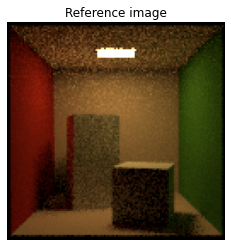

In [4]:
ek.set_log_level(3)
integrator = scene.integrator()
image_ref = integrator.render(scene)
show_image(image_ref, 'Reference image')

In [7]:
image_ref = integrator.render(scene)
ek.eval(image_ref)

2021-07-15 10:39:39 INFO main [SamplingIntegrator] Start rendering...

2021-07-15 10:39:39 INFO main [SamplingIntegrator] Computation graph recorded. (took 73ms)

jit_eval(): launching 1 kernel.
  -> launching 7846b0bed5694683 (via OptiX, n=2097152, in=29, out=5, ops=889, jit=6.9003 ms):
jit_eval(): done.


2021-07-15 10:39:39 INFO main [SamplingIntegrator] Code generation finished. (took 42ms)

2021-07-15 10:39:39 INFO main [SamplingIntegrator] Rendering finished. (took 121ms)

jit_eval(): launching 3 kernels.
  -> launching 7c5793235f3da5c6 (via OptiX, n=2097152, in=10, out=1, ops=450, jit=4.7253 ms):
  -> launching bd62160220cc88b5 (n=81920, in=2, out=1, ops=23, jit=18.112 us):
  -> launching 924e0aac849e24d6 (n=1, in=1, out=1, ops=7, jit=9.131 us):
jit_eval(): done.
jit_eval(): launching 1 kernel.
  -> launching 0456986711286857 (n=16384, in=2, out=3, ops=39, jit=24.173 us):
jit_eval(): done.
jit_eval(): launching 1 kernel.
  -> launching bd3cae2d31c8d08d (n=49152, in=1, out=1, ops=24, jit=21.398 us):
jit_eval(): done.


2021-07-15 10:17:53 INFO main [SamplingIntegrator] Start rendering...

2021-07-15 10:17:53 INFO main [SamplingIntegrator] Computation graph recorded. (took 54ms)

2021-07-15 10:17:53 INFO main [SamplingIntegrator] Code generation finished. (took 39ms)

2021-07-15 10:17:53 INFO main [SamplingIntegrator] Rendering finished. (took 99ms)

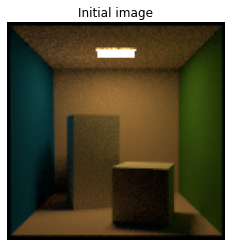

In [5]:
from mitsuba.core import Color3f, UInt32

# Update scene parameter
params = traverse(scene)
key = 'redwall.bsdf.reflectance.value'
params.keep([key])
param_ref = Color3f(params[key])
params[key] = Color3f(0.01, 0.2, 0.9)
params.update()

# Render initial image
scene.sensors()[0].sampler().seed(0)
image_init = integrator.render(scene, spp=128)
show_image(image_init, 'Initial image')

In [6]:
from mitsuba.python.ad import Adam

opt = Adam(lr=0.05, params=params)
opt.load(key)
opt.update()

In [7]:
def compute_image_loss(img, obj_func):  
    ek.enable_grad(img)
    ob_val = obj_func(img)
    ek.backward(ob_val)
    image_loss = ek.grad(img)
    ek.set_grad(img, 0.0)
    return image_loss
    
def MSE(img):
    return ek.hsum_async(ek.sqr(img - image_ref)) / len(img)

from mitsuba.core import Thread, LogLevel
Thread.thread().logger().set_log_level(LogLevel.Error)

errors = []
for it in range(5):    
    scene.sensors()[0].sampler().seed(0)
    
#     img = mitsuba.python.ad.render(scene)
#     loss = ...
#     ek.backward(loss)
    
    # Perform a differentiable rendering of the scene
    with opt.suspend_gradients():
        image = integrator.render(scene, spp=16)
    image_adj = compute_image_loss(image, MSE)
    integrator.render_backward(scene, opt, image_adj, spp=16)

    # Optimizer: take a gradient step
    opt.step()
    
    opt[key] = ek.clamp(opt[key], 0.0, 1.0)
    
    # Optimizer: Update the scene parameters
    opt.update()
        
    err_ref = ek.hsum(ek.sqr(param_ref - params[key]))
    print('Iteration %03i: error=%g' % (it, err_ref[0]))
    errors.append(err_ref)

Iteration 000: error=0.920995


KeyboardInterrupt: 

In [ ]:
scene.sensors()[0].sampler().seed(0)
image_final = integrator.render(scene, spp=8)
show_image(image_final, 'Final image')

In [ ]:
plt.plot(errors)
plt.xlabel('iteration'); plt.ylabel('MSE'); plt.title('Parameter error plot');

### *Reference API*

- [<code>mitsuba.core.xml.load_file</code>](https://mitsuba2.readthedocs.io/en/latest/generated/core_api.html#mitsuba.core.xml.load_file)